In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/LetterClassifier/notMNIST.npz'

# Load the data
def load_data():
    with np.load(path) as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(520)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target

def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test

def shuffle(data, target):
    np.random.seed(420)
    rand_idx = np.random.permutation(len(data))
    return data[rand_idx], target[rand_idx]

In [ ]:
######## PART 1 ########

# Implementation of neural network using only Numpy (trained using gradient descent with momentum)
def relu(x):
    output = np.maximum(x,0)
    return output

def softmax(x):
    input_z = x
    max_x_value = np.max(input_z)
    # In order to prevent overflow while computing exponentials, 
    # subtract the maximum value of z from all its elements
    updated_input_z = input_z-max_x_value
    part_one = np.exp(updated_input_z)
    part_two = np.sum(np.exp(updated_input_z), axis=1, keepdims=True)
    softmax_fn = part_one/part_two
    return softmax_fn

def compute_layer(x, w, b):
    layer_output = np.matmul(x,w)+b
    return layer_output

def average_ce(target, prediction):
    true_one_hot_label = target
    part_one = np.sum(true_one_hot_label*np.log(prediction))
    number_of_examples = true_one_hot_label.shape[0]
    crossEntropyLoss = part_one/number_of_examples
    avg_crossEntropyLoss = -1 * crossEntropyLoss
    return avg_crossEntropyLoss

def grad_ce(target, logits):
    input_to_softmax_function = logits
    prediction_for_gradient = softmax(input_to_softmax_function)
    labels_y = target
    crossEntropyLoss_gradient = prediction_for_gradient-labels_y
    return crossEntropyLoss_gradient

In [ ]:
######## PART 2 - BACKPROPAGATION DERIVATION ########

# gradient of the loss with respect to the output layer weights
def gradient_loss_wrt_output_layer_weights(target, logits, sm_fn):
    num_examples = target.shape[0]
    input_to_softmax_function = relu(sm_fn)
    gradient_ce = grad_ce(target, logits)
    avg_gradient_ce = gradient_ce/num_examples
    part_one = np.transpose(input_to_softmax_function)
    part_two = avg_gradient_ce
    dL_wo = np.matmul(part_one, part_two)
    return dL_wo

# gradient of the loss with respect to the output layer biases
def gradient_loss_wrt_output_layer_biases(target, logits):
    num_examples = target.shape[0]
    ones = np.ones((1, num_examples))
    gradient_ce = grad_ce(target, logits)
    avg_gradient_ce = gradient_ce/num_examples
    part_one = ones
    part_two = avg_gradient_ce
    dL_bo = np.matmul(part_one, part_two)
    return dL_bo

# gradient of the loss with respect to the hidden layer weights
def gradient_loss_wrt_hidden_layer_weights(target, logits, x_input, sm_fn, output_weights):
    sm_fn[sm_fn <= 0] = 0
    sm_fn[sm_fn > 0] = 1
    num_examples = target.shape[0]
    gradient_ce = grad_ce(target, logits)
    avg_gradient_ce = gradient_ce/num_examples
    part_one = np.transpose(x_input)
    part_two_a = np.transpose(output_weights)
    part_two = np.matmul(avg_gradient_ce, part_two_a)
    dL_wh = np.matmul(part_one, part_two*sm_fn)
    return dL_wh

# gradient of the loss with respect to the hidden layer biases
def gradient_loss_wrt_hidden_layer_biases(target, logits, sm_fn, output_weights):
    sm_fn[sm_fn <= 0] = 0
    sm_fn[sm_fn > 0] = 1
    num_examples = target.shape[0]
    ones = np.ones((1, num_examples))
    gradient_ce = grad_ce(target, logits)
    avg_gradient_ce = gradient_ce/num_examples
    part_one = ones
    part_two_a = np.transpose(output_weights)
    part_two = np.matmul(avg_gradient_ce, part_two_a)
    dL_bh = np.matmul(part_one, part_two*sm_fn)
    return dL_bh

# final calculation of the backpropagation derivatives
def backward_pass(target, logits, x_input, sm_fn, output_weights):
    dL_wo = gradient_loss_wrt_output_layer_weights(target, logits, sm_fn)
    dL_bo = gradient_loss_wrt_output_layer_biases(target, logits)
    dL_wh = gradient_loss_wrt_hidden_layer_weights(target, logits, x_input, sm_fn, output_weights)
    dL_bh = gradient_loss_wrt_hidden_layer_biases(target, logits, sm_fn, output_weights)
    return dL_wo, dL_bo, dL_wh, dL_bh

In [ ]:
######## PART 3 - LEARNING ########

def xavier_initializations(features_size):
    units_in = 1000
    units_out = 10
    denom_one = units_in + units_out
    denom_two = features_size + units_in
    inner_one = (2/denom_one)**0.5
    inner_two = (2/denom_two)**0.5

    # initialize weight matrices following the Xaiver initialization scheme (zero-mean Gaussians with variance 2/(units_in+units_out))
    output_weight = np.random.normal(0, inner_one, (1000, 10)) # Shape: H x 10 where H = 1000
    hidden_weight = np.random.normal(0, inner_two, (features_size, 1000)) # Shape: F x H where F = features and H = 1000

    # initialize bias vectors to zero
    output_biases = np.zeros((1, 10)) # Shape: 1 x 10
    hidden_biases = np.zeros((1, 1000)) # Shape: 1 x H where H = 1000

    return output_weight, output_biases, hidden_weight, hidden_biases

In [ ]:
def xavier_initializations_two(features_size):
    units_in = 1000
    units_out = 10
    param = 1e-5
    # for v matrices, initialize them to the same size as the hidden and output layer weight matrix sizes, with a very small value 10e-5
    output_weights_matv = np.full((1000, 10), param) # Shape: H x 10 where H = 1000
    output_biases_matv = np.full((1, 10), param) # Shape: 1 x 10
    hidden_weights_matv = np.full((features_size, 1000), param) # Shape: F x H where F = features and H = 1000
    hidden_biases_matv = np.full((1, 1000), param) # Shape: 1 x H where H = 1000

    return output_weights_matv, output_biases_matv, hidden_weights_matv, hidden_biases_matv

In [ ]:
def update_output_layer_weight(wo_stepsize, output_weights, der_output_weights):
    part_one = (0.99*wo_stepsize)
    part_two = (0.1*der_output_weights)
    wo_stepsize = (part_one) + (part_two)
    output_weights = output_weights - wo_stepsize
    return output_weights

In [ ]:
def update_output_layer_biases(bo_stepsize, output_biases, der_output_biases):
    part_one = (0.99*bo_stepsize)
    part_two = (0.1*der_output_biases)
    bo_stepsize = (part_one) + (part_two)
    output_biases = output_biases - bo_stepsize
    return output_biases

In [ ]:
def update_hidden_layer_weights(wh_stepsize, hidden_weights, der_hidden_weights):
    part_one = (0.99*wh_stepsize)
    part_two = (0.1*der_hidden_weights)
    wh_stepsize = (part_one) + (part_two)
    hidden_weights = hidden_weights - wh_stepsize
    return hidden_weights

In [ ]:
def update_hidden_layer_biases(bh_stepsize, hidden_biases, der_hidden_biases):
    part_one = (0.99*bh_stepsize)
    part_two = (0.1*der_hidden_biases)
    bh_stepsize = (part_one) + (part_two)
    hidden_biases = hidden_biases - bh_stepsize
    return hidden_biases

In [ ]:
def forward_pass_one(data_input, output_weights, output_biases, hidden_weights, hidden_biases):
    data = data_input
    output_one = compute_layer(relu(compute_layer(data, hidden_weights, hidden_biases)), output_weights, output_biases)
    return output_one

In [ ]:
def forward_pass(data_input, output_weights, output_biases, hidden_weights, hidden_biases):
    data = data_input
    softmax_z = compute_layer(data, hidden_weights, hidden_biases)
    x_check = relu(softmax_z)
    pre_pred = compute_layer(x_check, output_weights, output_biases)
    output = softmax(pre_pred)
    return output

In [ ]:
def accuracy_fn(fw_pass, updated_dataset, num_of_examples):
    prediction_result = np.argmax(fw_pass, axis = 1)
    t_result = np.argmax(updated_dataset, axis = 1)
    accuracy = np.sum((prediction_result==t_result))
    final_accuracy = accuracy/num_of_examples
    return final_accuracy

In [ ]:
def neural_network():

    # data
    train_data, valid_data, test_data, train_target, valid_target, test_target = load_data()
    updated_training_target, updated_validation_target, updated_test_target = convert_onehot(train_target, valid_target, test_target)
    train_data = train_data.reshape(-1, 28*1*28)
    valid_data = valid_data.reshape(-1, 784)
    test_data = test_data.reshape(-1, 28*1*28)
    
    # xavier initializations
    num_of_tr_examples = train_data.shape[0]
    num_of_vl_examples = valid_data.shape[0]
    features_size = train_data.shape[1]
    output_weights, output_biases, hidden_weights, hidden_biases = xavier_initializations(features_size)
    wo_stepsize, bo_stepsize, wh_stepsize, bh_stepsize = xavier_initializations_two(features_size)

    # final output list initializations
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for i in range(200):
        # calculating training loss
        tr_fw_pass = forward_pass(train_data, output_weights, output_biases, hidden_weights, hidden_biases)
        tr_loss = average_ce(updated_training_target, tr_fw_pass)
        training_loss.append(tr_loss)
        # checking training accuracy
        training_acc = accuracy_fn(tr_fw_pass, updated_training_target, num_of_tr_examples)
        training_accuracy.append(training_acc)

        # calculating validation loss 
        vl_fw_pass = forward_pass(valid_data, output_weights, output_biases, hidden_weights, hidden_biases)
        val_loss = average_ce(updated_validation_target, vl_fw_pass)
        validation_loss.append(val_loss)
        # checking validation accuracy
        validation_acc = accuracy_fn(vl_fw_pass, updated_validation_target, num_of_vl_examples)
        validation_accuracy.append(validation_acc)

        # using gradients to update network's weights and biases 
        tr_log = forward_pass_one(train_data, output_weights, output_biases, hidden_weights, hidden_biases)
        wo_grad, bo_grad, wh_grad, bh_grad = backward_pass(updated_training_target, tr_log, train_data, compute_layer(train_data, hidden_weights, hidden_biases), output_weights)
        output_weights = update_output_layer_weight(wo_stepsize, output_weights, wo_grad)
        output_biases = update_output_layer_biases(bo_stepsize, output_biases, bo_grad)
        hidden_weights = update_hidden_layer_weights(wh_stepsize, hidden_weights, wh_grad)
        hidden_biases = update_hidden_layer_biases(bh_stepsize, hidden_biases, bh_grad)

    return training_loss, validation_loss, training_accuracy, validation_accuracy

In [ ]:
def plot_neural_network():

    training_loss, validation_loss, training_accuracy, validation_accuracy = neural_network()

    plt.title("Training & Validation Loss") 
    plt.plot(training_loss, label='training dataset') 
    plt.plot(validation_loss, label='validation dataset')   
    plt.xlabel('# of epochs')   
    plt.ylabel('Loss')
    plt.show()

    plt.title("Training & Validation Accuracy") 
    plt.plot(training_accuracy, label='training dataset') 
    plt.plot(validation_accuracy, label='validation dataset')   
    plt.xlabel('# of epochs')   
    plt.ylabel('Accuracy')
    plt.show()

    epochs = 200
    final_training_point = epochs-1
    final_validation_point = epochs-1
    print_one = training_accuracy[final_training_point]
    print_two = validation_accuracy[final_validation_point]

    print("The Final Training Accuracy is ", print_one)
    print("The Final Validation Accuracy is ", print_two)

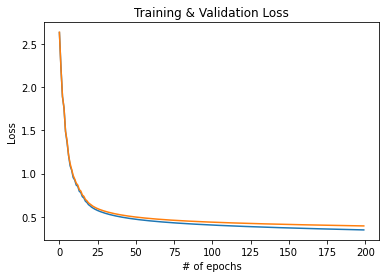

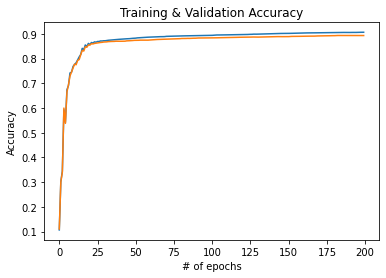

The Final Training Accuracy is  0.9063
The Final Validation Accuracy is  0.893


In [ ]:
plot_neural_network()